In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
def load_data():
    train = pd.read_csv("/kaggle/input/titanic/train.csv")
    train.name = 'train'
    test = pd.read_csv("/kaggle/input/titanic/test.csv")
    test.name = 'test'
    return train, test

In [3]:
train_data, test_data = load_data()
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def clean_data(df):
    name = df.name
    df['Sex'] = df['Sex'].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df, columns=['Embarked'])
    df = df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)
    if name != 'test':
        X_train = df.drop('Survived', axis = 1)
        X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
        y_train = df['Survived']
        return X_train, y_train
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    return df

In [5]:
X_train, y_train = clean_data(train_data)
X_test = clean_data(test_data)

In [6]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,False
2,3,1,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,3,0,35.0,0,0,8.0500,False,False,True


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [10]:
print(X_train.shape)
print(X_val.shape)

(712, 9)
(179, 9)


In [55]:
from numpy import mean, std
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')

input_shape = X_train.shape

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(9,)),
    Dense(512, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dropout(0.4),
    Dense(512, activation = 'relu'),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.AdamW(1e-4),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = ["accuracy"])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 512)               5120      
                                                                 
 dense_70 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_22 (Dropout)        (None, 1024)              0         
                                                                 
 dense_71 (Dense)            (None, 512)               524800    
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_72 (Dense)            (None, 128)               65664     
                                                                 
 dense_73 (Dense)            (None, 64)              

In [56]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), batch_size = 16)#.79

Epoch 1/100
45/45 [==============================] - 2s 17ms/step - loss: 0.6801 - accuracy: 0.6362 - val_loss: 0.5916 - val_accuracy: 0.6536
Epoch 2/100
45/45 [==============================] - 1s 14ms/step - loss: 0.6386 - accuracy: 0.6657 - val_loss: 0.5663 - val_accuracy: 0.7263
Epoch 3/100
45/45 [==============================] - 1s 14ms/step - loss: 0.6436 - accuracy: 0.6615 - val_loss: 0.5772 - val_accuracy: 0.7207
Epoch 4/100
45/45 [==============================] - 1s 13ms/step - loss: 0.6435 - accuracy: 0.6461 - val_loss: 0.5697 - val_accuracy: 0.7263
Epoch 5/100
45/45 [==============================] - 1s 13ms/step - loss: 0.6432 - accuracy: 0.6685 - val_loss: 0.5745 - val_accuracy: 0.7263
Epoch 6/100
45/45 [==============================] - 1s 13ms/step - loss: 0.6450 - accuracy: 0.6713 - val_loss: 0.5736 - val_accuracy: 0.7263
Epoch 7/100
45/45 [==============================] - 1s 12ms/step - loss: 0.6302 - accuracy: 0.6756 - val_loss: 0.5684 - val_accuracy: 0.7207
Epoch 

In [57]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

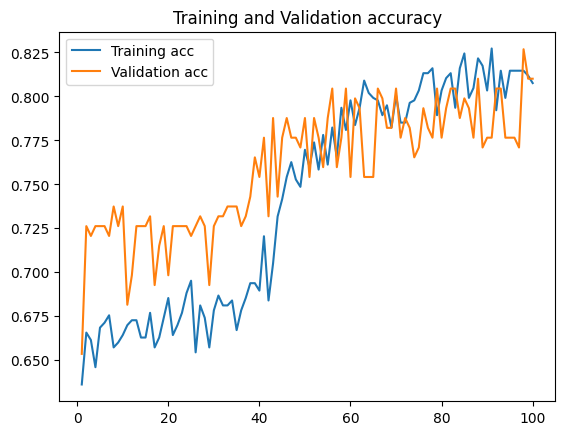

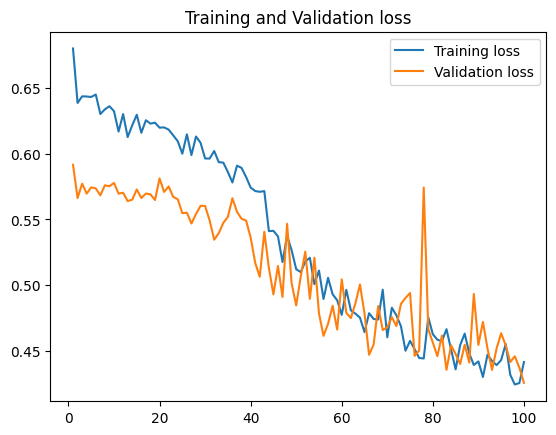

In [58]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, train_acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [59]:
val_preds = model.predict(X_val)
val_preds[val_preds>=0.5] = 1
val_preds[val_preds<0.5] = 0

from sklearn.metrics import classification_report

print(classification_report(y_val, val_preds))

6/6 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       105
         1.0       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [60]:
y_pred = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


In [61]:
output = np.c_[test_data["PassengerId"].to_numpy(), y_pred].astype(int)
output = pd.DataFrame(output, columns = ['PassengerId', 'Survived'])
output.to_csv("Dropout_submission2.csv", index = False)